# KE5105 - Building Electrical Consumption Forecasting

# Modelling 10 - Model Fine-tuning

## Summary of Findings
* **MRB Data**
* 4x128 GRU, 2x32 Dense Model
	* L1 (3e-7), L2 (3e-7) Weight Regularisation
		* Minimum Validation Loss (normalised) = xxx (xxx) @ epoch xxx


## Load libraries

In [1]:
import os
os.chdir(os.path.join(os.path.sep, 'home', 'tkokkeng', 'Documents', 'KE5105', 'ETL'))
os.getcwd()

'/home/tkokkeng/Documents/KE5105/ETL'

In [2]:
import sys
if os.path.join(os.getcwd(), 'source') not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'source'))
sys.path

['/home/tkokkeng/python/python367/tsfvenv/lib/python36.zip',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages',
 '/home/tkokkeng/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages/IPython/extensions',
 '/home/tkokkeng/.ipython',
 '/home/tkokkeng/Documents/KE5105/ETL/source']

In [26]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import datetime
import myUtilities as mu
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from keras.models import Sequential, load_model
from keras import layers
from keras.regularizers import l1,l2, l1_l2
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback
import keras.backend as K

## Load data for building MRB

In [4]:
mrb_train = mu.load_data_by_bldg(['MRB'], 'imputed_train')

In [5]:
mrb_train[0][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31617 entries, 2015-06-12 07:30:00 to 2017-03-31 23:30:00
Data columns (total 10 columns):
PWMMRIC1                     29851 non-null float64
PWMMRIC2                     29851 non-null float64
BTUMochtarRiady              29448 non-null float64
PWMMRIC1_30min_avg           29818 non-null float64
PWMMRIC2_30min_avg           29818 non-null float64
BTUMochtarRiady_30min_avg    29416 non-null float64
PWM_sumadd                   29818 non-null float64
PWM_30min_avg                29861 non-null float64
BTU_sumadd                   29416 non-null float64
BTU_30min_avg                29469 non-null float64
dtypes: float64(10)
memory usage: 2.7 MB


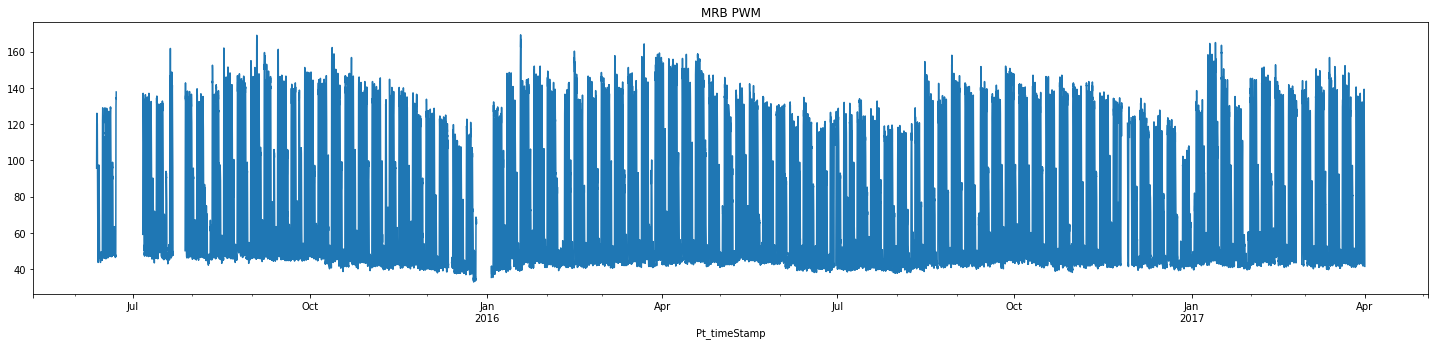

In [6]:
mrb_train_df = mrb_train[0][1]
mrb_train_df['PWM_30min_avg'].plot(figsize=(25, 5), title='MRB PWM')

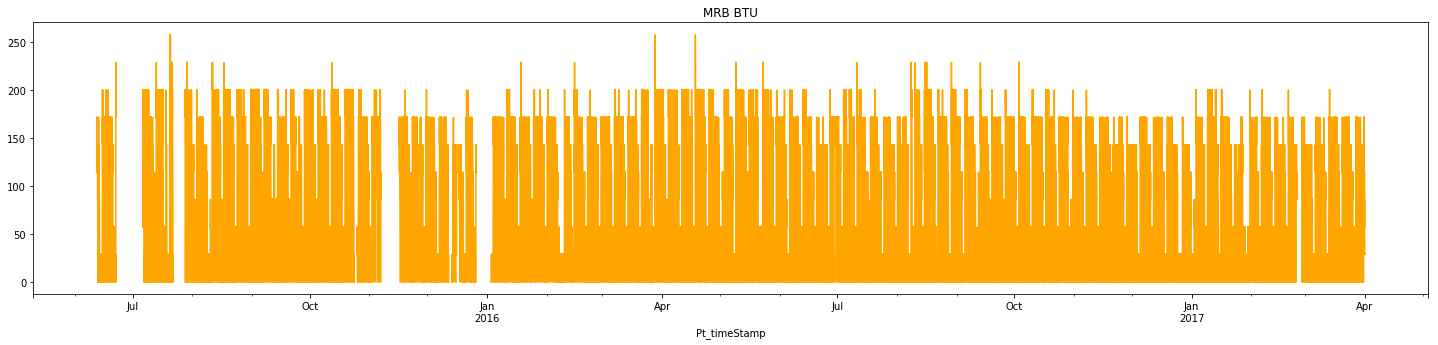

In [7]:
mrb_train_df['BTU_30min_avg'].plot(figsize=(25, 5), title='MRB BTU', color='orange')

## Split a validation set out from the train set

In [8]:
mrb_train_split_df = mrb_train_df[:20000]
mrb_val_split_df = mrb_train_df[20000:]

In [9]:
print('train split = %s\nvalidation split = %s' % (mrb_train_split_df.shape, mrb_val_split_df.shape))

train split = (20000, 10)
validation split = (11617, 10)


## Transform the training data

* Normalise the data - convert PWM and BTU values into the range 0 to 1
* Replace NaN with -1

In [10]:
# Create a transformation pipleline to prepare the training dataset for RNN.
attrbs = ['PWM_30min_avg', 'BTU_30min_avg']
my_pipeline = Pipeline([
    ('selector', mu.DataFrameSelector(attrbs)),
    ('minmax_scaler', MinMaxScaler()),
    ('na_transform', mu.Nan_to_Num_Transformer())
])

In [11]:
mrb_train_data = my_pipeline.fit_transform(mrb_train_split_df)
mrb_train_data

array([[0.46055046, 0.66601942],
       [0.55412844, 0.66699029],
       [0.60366972, 0.66601942],
       ...,
       [0.16880734, 0.11067961],
       [0.07889908, 0.11067961],
       [0.07155963, 0.        ]])

In [12]:
mrb_train_data.shape

(20000, 2)

Text(0.5, 1.0, 'Normalised PWM Training Data')

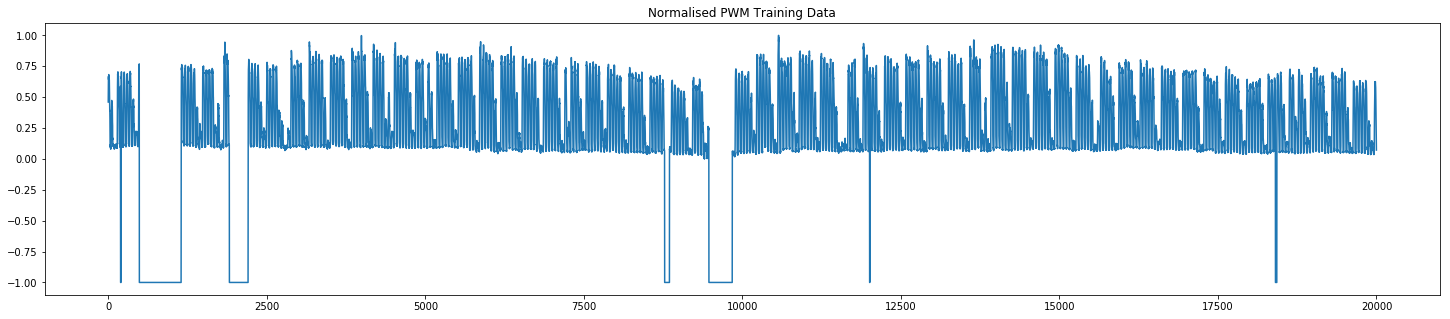

In [13]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_train_data.shape[0]), mrb_train_data[:, 0])
plt.title('Normalised PWM Training Data')

Text(0.5, 1.0, 'Normalised BTU Training Data')

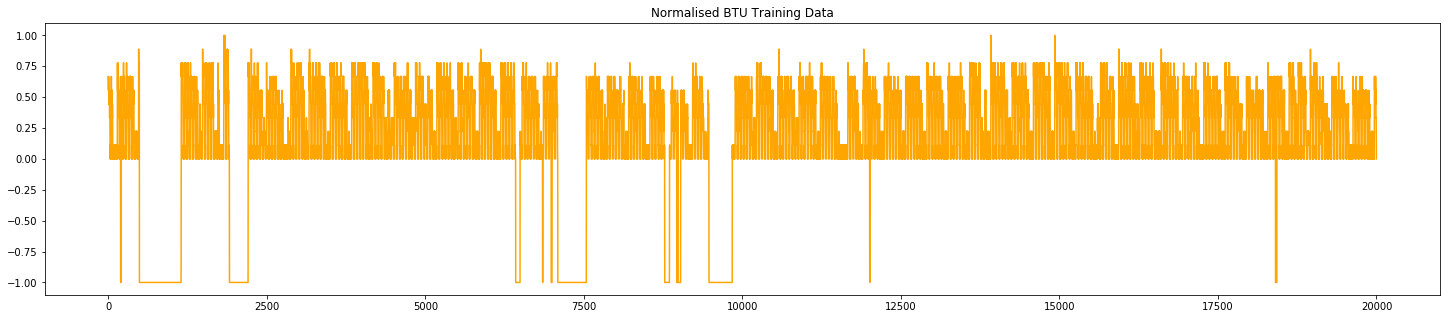

In [14]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_train_data.shape[0]), mrb_train_data[:, 1], color='orange')
plt.title('Normalised BTU Training Data')

In [15]:
mrb_val_data = my_pipeline.transform(mrb_val_split_df)
mrb_val_data

array([[0.05321101, 0.        ],
       [0.07155963, 0.11067961],
       [0.05688073, 0.        ],
       ...,
       [0.13211009, 0.11067961],
       [0.10825688, 0.11426533],
       [0.06314127, 0.11424788]])

In [16]:
mrb_val_data.shape

(11617, 2)

Text(0.5, 1.0, 'Normalised PWM Validation Data')

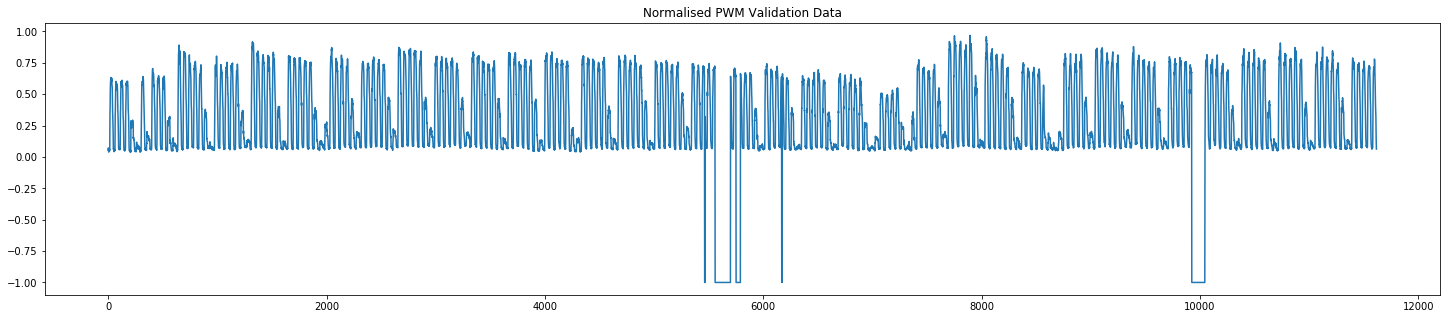

In [17]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_val_data.shape[0]), mrb_val_data[:, 0])
plt.title('Normalised PWM Validation Data')

Text(0.5, 1.0, 'Normalised BTU Validation Data')

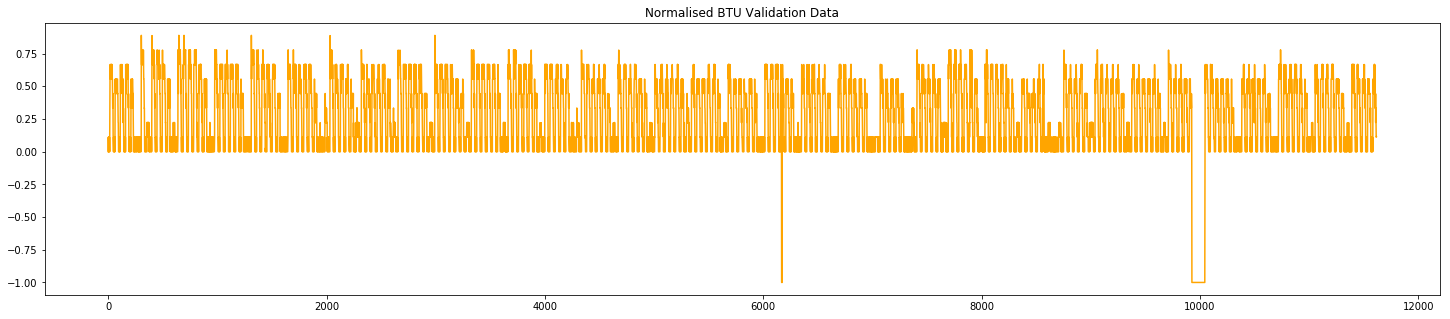

In [18]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_val_data.shape[0]), mrb_val_data[:, 1], color='orange')
plt.title('Normalised BTU Validation Data')

## Parameters for the RNN model

Also used for generating the datasets with the lagged values 

In [19]:
lookback = 240  # 5 days; each day has 48 observations
step = 1  # sampling rate used for the lookback period
delay = 0  # 1 step ahead prediction
batch_size = 128

In [20]:
# Custom mape metric. Skips all zero values of y-true in computing the mape metric.
import tensorflow as tf
def mape_skip_zeros(y_true, y_pred):
    y_true1 = tf.boolean_mask(y_true, y_true > 0)
    y_pred1 = tf.boolean_mask(y_pred, y_true > 0)
    diff = K.abs((y_true1 - y_pred1) / y_true1)
    return 100. * K.mean(diff, axis=-1)

## 4x128 GRU, 2x32 Dense with Weights Regularization (L1L2 3e-7) and Adam

In [21]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [22]:
model = Sequential()
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(3e-7, 3e-7), recurrent_regularizer=l1_l2(3e-7, 3e-7),
                          bias_regularizer=l1_l2(3e-7, 3e-7), return_sequences=True, input_shape=(None, mrb_train_data.shape[-1])))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(3e-7, 3e-7), recurrent_regularizer=l1_l2(3e-7, 3e-7),
                          bias_regularizer=l1_l2(3e-7, 3e-7), return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(3e-7, 3e-7), recurrent_regularizer=l1_l2(3e-7, 3e-7),
                          bias_regularizer=l1_l2(3e-7, 3e-7), return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(3e-7, 3e-7), recurrent_regularizer=l1_l2(3e-7, 3e-7),
                          bias_regularizer=l1_l2(3e-7, 3e-7)))
model.add(layers.Dense(32, kernel_regularizer=l1_l2(3e-7, 3e-7), bias_regularizer=l1_l2(3e-7, 3e-7)))
model.add(layers.Dense(32, kernel_regularizer=l1_l2(3e-7, 3e-7), bias_regularizer=l1_l2(3e-7, 3e-7)))
model.add(layers.Dense(1))
model.compile(optimizer=Adam(), loss='mae', metrics=[mape_skip_zeros])

In [23]:
gen_train = mu.DataGenerator(mrb_train_data,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                             batch_size=batch_size, step=step, shuffle=True)
gen_val = mu.DataGenerator(mrb_val_data,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 144
test batches = 87


In [24]:
callbacks_list = [
    ModelCheckpoint(
        filepath=os.path.join('MRB-wgtreg1-4x128gru-2x32dense.best-epchxxx.h5'),
        monitor='val_loss',
        save_best_only=True
    ),
    TensorBoard(
        log_dir='tsb_log'
    )
]

In [25]:
histories = []

In [22]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('final results', 'models', 'MRB-wgtreg-4x128gru-2x32dense-histories-epchxxx.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('final results', 'models', 'MRB-wgtreg-4x128gru-2x32dense-epchxxx.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, None, 128)         50688     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [36]:
train_to_epoch = 700
start_epoch = 600
t1 = datetime.datetime.now()
print('Training start time = %s' % t1)
history = model.fit_generator(generator=gen_train, epochs=train_to_epoch,
                              callbacks=callbacks_list,
                              initial_epoch = start_epoch,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=0)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))
histories.append(history.history)

Training start time = 2019-03-18 13:22:59.567759

Training Duration = 0:20:48.268349


In [37]:
model.save('MRB-wgtreg1-4x128gru-2x32dense-epch' + str(train_to_epoch) + '.h5')

In [38]:
with open('MRB-wgtreg1-4x128gru-2x32dense-histories-epch' + str(train_to_epoch) + '.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

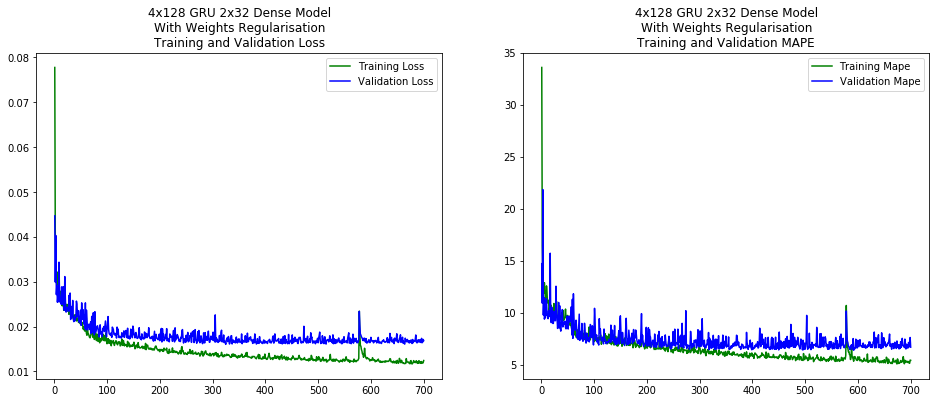

In [39]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mape_skip_zeros']:
        train_mape.append(a_mape)
    for a_mape in h['val_mape_skip_zeros']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model\nWith Weights Regularisation\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model\nWith Weights Regularisation\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [40]:
print('Min Training Loss = {}\nMin Validation Loss = {} @ epoch {}\nMin Train MAE = {}\nMin Validation MAE = {}'.format(
    min(train_loss),
    min(val_loss),
    val_loss.index(min(val_loss)),
    min(train_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min()),
    min(val_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min())))

Min Training Loss = 0.01165840352889389
Min Validation Loss = 0.016037664130086247 @ epoch 324
Min Train MAE = 1.5884574808117926
Min Validation MAE = 2.185131737724251


After 500 epochs
* Min Training Loss = 0.012281467761524436
* Min Validation Loss = 0.016037664130086247 @ epoch 324
* Min Train MAE = 1.6733499825077045
* Min Validation MAE = 2.185131737724251

## 4x128 GRU, 2x32 Dense with Weights Regularization (L1L2 3e-7) on Recurrent Layers Only and Adam

In [21]:
from numpy.random import seed
# seed(123)
seed(92)

from tensorflow import set_random_seed
# set_random_seed(456)
set_random_seed(105)

In [22]:
model = Sequential()
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(3e-7, 3e-7), recurrent_regularizer=l1_l2(3e-7, 3e-7),
                          bias_regularizer=l1_l2(3e-7, 3e-7), return_sequences=True, input_shape=(None, mrb_train_data.shape[-1])))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(3e-7, 3e-7), recurrent_regularizer=l1_l2(3e-7, 3e-7),
                          bias_regularizer=l1_l2(3e-7, 3e-7), return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(3e-7, 3e-7), recurrent_regularizer=l1_l2(3e-7, 3e-7),
                          bias_regularizer=l1_l2(3e-7, 3e-7), return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(3e-7, 3e-7), recurrent_regularizer=l1_l2(3e-7, 3e-7),
                          bias_regularizer=l1_l2(3e-7, 3e-7)))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=Adam(), loss='mae', metrics=[mape_skip_zeros])

In [23]:
gen_train = mu.DataGenerator(mrb_train_data,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                             batch_size=batch_size, step=step, shuffle=True)
gen_val = mu.DataGenerator(mrb_val_data,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 144
test batches = 87


In [24]:
callbacks_list = [
    ModelCheckpoint(
        filepath=os.path.join('MRB-wgtreg20-4x128gru-2x32dense.best-epchxxx.h5'),
        monitor='val_loss',
        save_best_only=True
    ),
    TensorBoard(
        log_dir='tsb_log'
    )
]

In [25]:
histories = []

In [22]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('final results', 'models', 'MRB-wgtreg20-4x128gru-2x32dense-histories-epchxxx.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('final results', 'models', 'MRB-wgtreg20-4x128gru-2x32dense-epchxxx.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, None, 128)         50688     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [31]:
train_to_epoch = 700
start_epoch = 500
t1 = datetime.datetime.now()
print('Training start time = %s' % t1)
history = model.fit_generator(generator=gen_train, epochs=train_to_epoch,
                              callbacks=callbacks_list,
                              initial_epoch = start_epoch,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=0)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))
histories.append(history.history)

Training start time = 2019-03-19 15:57:25.267959

Training Duration = 0:41:23.790283


In [32]:
model.save('MRB-wgtreg20-4x128gru-2x32dense-epch' + str(train_to_epoch) + '.h5')

In [33]:
with open('MRB-wgtreg20-4x128gru-2x32dense-histories-epch' + str(train_to_epoch) + '.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

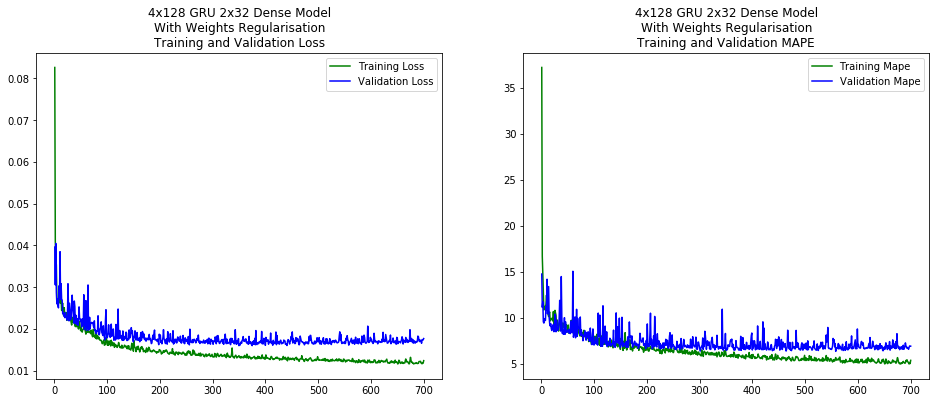

In [34]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mape_skip_zeros']:
        train_mape.append(a_mape)
    for a_mape in h['val_mape_skip_zeros']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model\nWith Weights Regularisation\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model\nWith Weights Regularisation\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [35]:
print('Min Training Loss = {}\nMin Validation Loss = {} @ epoch {}\nMin Train MAE = {}\nMin Validation MAE = {}'.format(
    min(train_loss),
    min(val_loss),
    val_loss.index(min(val_loss)),
    min(train_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min()),
    min(val_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min())))

Min Training Loss = 0.011598021338472122
Min Validation Loss = 0.015987647314225126 @ epoch 349
Min Train MAE = 1.5802304073668265
Min Validation MAE = 2.1783169465631733


Run 1

After 500 epochs
* Min Training Loss = 0.012435920745793791
* Min Validation Loss = 0.01575298880658597 @ epoch 387
* Min Train MAE = 1.694394201614404
* Min Validation MAE = 2.1463447248973386

After 700 epochs
* Min Training Loss = 0.011784156632057662
* Min Validation Loss = 0.01575298880658597 @ epoch 387
* Min Train MAE = 1.6055913411178564
* Min Validation MAE = 2.1463447248973386

Run 2

After 500 epochs
* Min Training Loss = 0.012197133268021404
* Min Validation Loss = 0.015987647314225126 @ epoch 349
* Min Train MAE = 1.6618594077679163
* Min Validation MAE = 2.1783169465631733

After 700 epochs
* Min Training Loss = 0.011598021338472122
* Min Validation Loss = 0.015987647314225126 @ epoch 349
* Min Train MAE = 1.5802304073668265
* Min Validation MAE = 2.1783169465631733

## Retrain from best model using a smaller learning rate 0.0005

In [21]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [22]:
gen_train = mu.DataGenerator(mrb_train_data,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                             batch_size=batch_size, step=step, shuffle=True)
gen_val = mu.DataGenerator(mrb_val_data,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 144
test batches = 87


In [23]:
callbacks_list = [
    ModelCheckpoint(
        filepath=os.path.join('MRB-wgtreg3-4x128gru-2x32dense.best-epchxxx.h5'),
        monitor='val_loss',
        save_best_only=True
    ),
    TensorBoard(
        log_dir='tsb_log'
    )
]

In [24]:
histories = []

In [25]:
# Load best model
from keras.models import load_model
model = load_model(os.path.join('final results', 'models', 'MRB-wgtreg2-4x128gru-2x32dense.best-epch387.h5'),
                  custom_objects={'mape_skip_zeros': mape_skip_zeros})
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, None, 128)         50688     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [26]:
K.set_value(model.optimizer.lr, 0.0005)

In [27]:
train_to_epoch = 500
start_epoch = 387
t1 = datetime.datetime.now()
print('Training start time = %s' % t1)
history = model.fit_generator(generator=gen_train, epochs=train_to_epoch,
                              callbacks=callbacks_list,
                              initial_epoch = start_epoch,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=0)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))
histories.append(history.history)

Training start time = 2019-03-19 10:26:04.896079

Training Duration = 0:24:03.242338


In [28]:
model.save('MRB-wgtreg3-4x128gru-2x32dense-epch' + str(train_to_epoch) + '.h5')

In [29]:
with open('MRB-wgtreg3-4x128gru-2x32dense-histories-epch' + str(train_to_epoch) + '.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

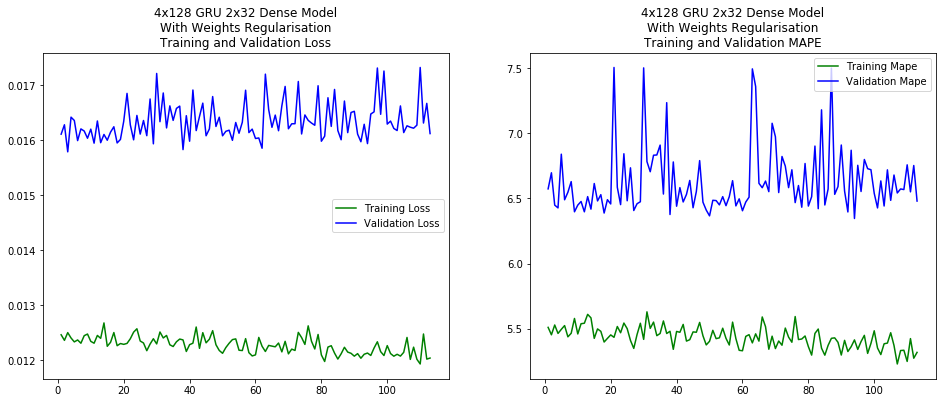

In [30]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mape_skip_zeros']:
        train_mape.append(a_mape)
    for a_mape in h['val_mape_skip_zeros']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model\nWith Weights Regularisation\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model\nWith Weights Regularisation\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [31]:
print('Min Training Loss = {}\nMin Validation Loss = {} @ epoch {}\nMin Train MAE = {}\nMin Validation MAE = {}'.format(
    min(train_loss),
    min(val_loss),
    val_loss.index(min(val_loss)),
    min(train_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min()),
    min(val_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min())))

Min Training Loss = 0.011928751788093045
Min Validation Loss = 0.015789380430267234 @ epoch 2
Min Train MAE = 1.6252924311276775
Min Validation MAE = 2.1513030836239104


After 500 epochs


## Retrain from best model using a smaller learning rate 0.0002

In [21]:
from numpy.random import seed
# seed(123)
seed(43)

from tensorflow import set_random_seed
# set_random_seed(456)
set_random_seed(114)

In [22]:
gen_train = mu.DataGenerator(mrb_train_data,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                             batch_size=batch_size, step=step, shuffle=True)
gen_val = mu.DataGenerator(mrb_val_data,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 144
test batches = 87


In [23]:
callbacks_list = [
    ModelCheckpoint(
        filepath=os.path.join('MRB-wgtreg4-4x128gru-2x32dense.best-epchxxx.h5'),
        monitor='val_loss',
        save_best_only=True
    ),
    TensorBoard(
        log_dir='tsb_log'
    )
]

In [24]:
histories = []

In [25]:
# Load best model
from keras.models import load_model
model = load_model(os.path.join('final results', 'models', 'MRB-wgtreg2-4x128gru-2x32dense.best-epch387.h5'),
                  custom_objects={'mape_skip_zeros': mape_skip_zeros})
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, None, 128)         50688     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [26]:
K.set_value(model.optimizer.lr, 0.0002)

In [27]:
train_to_epoch = 500
start_epoch = 387
t1 = datetime.datetime.now()
print('Training start time = %s' % t1)
history = model.fit_generator(generator=gen_train, epochs=train_to_epoch,
                              callbacks=callbacks_list,
                              initial_epoch = start_epoch,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=0)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))
histories.append(history.history)

Training start time = 2019-03-19 13:25:19.159578

Training Duration = 0:24:03.595768


In [28]:
model.save('MRB-wgtreg4-4x128gru-2x32dense-epch' + str(train_to_epoch) + '.h5')

In [29]:
with open('MRB-wgtreg4-4x128gru-2x32dense-histories-epch' + str(train_to_epoch) + '.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

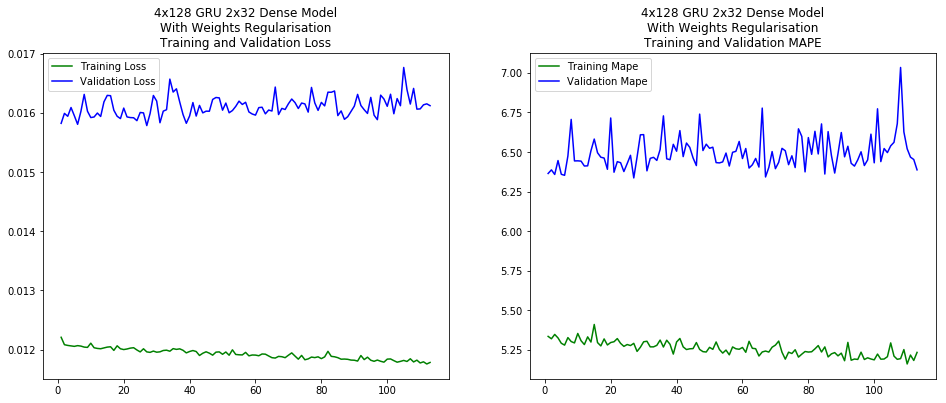

In [30]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mape_skip_zeros']:
        train_mape.append(a_mape)
    for a_mape in h['val_mape_skip_zeros']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model\nWith Weights Regularisation\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model\nWith Weights Regularisation\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [31]:
print('Min Training Loss = {}\nMin Validation Loss = {} @ epoch {}\nMin Train MAE = {}\nMin Validation MAE = {}'.format(
    min(train_loss),
    min(val_loss),
    val_loss.index(min(val_loss)),
    min(train_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min()),
    min(val_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min())))

Min Training Loss = 0.011757711090983378
Min Validation Loss = 0.015783727221913693 @ epoch 26
Min Train MAE = 1.6019881361464852
Min Validation MAE = 2.1505328339857406


After 500 epochs

Run 1
* Min Training Loss = 0.011753582247067091
* Min Validation Loss = 0.01573379730406484 @ epoch 0
* Min Train MAE = 1.6014255811628912
* Min Validation MAE = 2.1437298826788345

Run 2
* Min Training Loss = 0.011757711090983378
* Min Validation Loss = 0.015783727221913693 @ epoch 26
* Min Train MAE = 1.6019881361464852
* Min Validation MAE = 2.1505328339857406


## 4x128 GRU, 2x32 Dense with Weights Regularization (L1L2 3e-7) on Recurrent Layers Only and SGD with Warm Restarts

In [21]:
from numpy.random import seed
seed(123)
# seed(92)

from tensorflow import set_random_seed
set_random_seed(456)
# set_random_seed(105)

In [22]:
model = Sequential()
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(3e-7, 3e-7), recurrent_regularizer=l1_l2(3e-7, 3e-7),
                          bias_regularizer=l1_l2(3e-7, 3e-7), return_sequences=True, input_shape=(None, mrb_train_data.shape[-1])))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(3e-7, 3e-7), recurrent_regularizer=l1_l2(3e-7, 3e-7),
                          bias_regularizer=l1_l2(3e-7, 3e-7), return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(3e-7, 3e-7), recurrent_regularizer=l1_l2(3e-7, 3e-7),
                          bias_regularizer=l1_l2(3e-7, 3e-7), return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(3e-7, 3e-7), recurrent_regularizer=l1_l2(3e-7, 3e-7),
                          bias_regularizer=l1_l2(3e-7, 3e-7)))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False),
              loss='mae',
              metrics=[mape_skip_zeros])

In [23]:
gen_train = mu.DataGenerator(mrb_train_data,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                             batch_size=batch_size, step=step, shuffle=True)
gen_val = mu.DataGenerator(mrb_val_data,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 144
test batches = 87


In [27]:
class WarmRestart(Callback):
    def __init__(self,
             min_lr,
             max_lr,
             steps_per_epoch,
             lr_decay=1,
             cycle_length=10,
             mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}
    
    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        # logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        # logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        # for k, v in logs.items():
        #     self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            # self.best_weights = self.model.get_weights()

#     def on_train_end(self, logs={}):
#         '''Set weights to the values from the end of the most recent cycle for best performance.'''
#         self.model.set_weights(self.best_weights)  

In [29]:
wr = WarmRestart(min_lr=0.0001,
                 max_lr=0.02,  # keras default lr for rmsprop is 0.001
                 steps_per_epoch=gen_train.__len__(),
                 lr_decay=1,  # 10% decay is 0.9
                 cycle_length=10,  # number of epochs in a cycle
                 mult_factor=1)  # scale factor to increase cycle length after each cycle

In [30]:
callbacks_list = [
    ModelCheckpoint(
        filepath=os.path.join('MRB-wgtreg5-4x128gru-2x32dense.best-epchxxx.h5'),
        monitor='val_loss',
        save_best_only=True
    ),
    TensorBoard(
        log_dir='tsb_log'
    ),
    wr
]

In [31]:
histories = []

In [ ]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('final results', 'models', 'MRB-wgtreg5-4x128gru-2x32dense-histories-epchxxx.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('final results', 'models', 'MRB-wgtreg5-4x128gru-2x32dense-epchxxx.h5'))
model.summary()

In [34]:
train_to_epoch = 50
start_epoch = 5
t1 = datetime.datetime.now()
print('Training start time = %s' % t1)
history = model.fit_generator(generator=gen_train, epochs=train_to_epoch,
                              callbacks=callbacks_list,
                              initial_epoch = start_epoch,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))
histories.append(history.history)

Training start time = 2019-03-19 17:49:34.300970
Epoch 6/50
 - 12s - loss: 0.0444 - mape_skip_zeros: 19.7235 - val_loss: 0.0414 - val_mape_skip_zeros: 18.1272
Epoch 7/50
 - 12s - loss: 0.0406 - mape_skip_zeros: 16.7581 - val_loss: 0.0382 - val_mape_skip_zeros: 15.1241
Epoch 8/50
 - 13s - loss: 0.0385 - mape_skip_zeros: 15.1834 - val_loss: 0.0375 - val_mape_skip_zeros: 14.3535
Epoch 9/50
 - 13s - loss: 0.0379 - mape_skip_zeros: 14.9418 - val_loss: 0.0371 - val_mape_skip_zeros: 13.8687
Epoch 10/50
 - 13s - loss: 0.0375 - mape_skip_zeros: 14.5189 - val_loss: 0.0370 - val_mape_skip_zeros: 13.7533
Epoch 11/50
 - 13s - loss: 0.0569 - mape_skip_zeros: 31.5313 - val_loss: 0.0436 - val_mape_skip_zeros: 18.2148
Epoch 12/50
 - 13s - loss: 0.0456 - mape_skip_zeros: 21.0746 - val_loss: 0.0738 - val_mape_skip_zeros: 61.1886
Epoch 13/50
 - 13s - loss: 0.0487 - mape_skip_zeros: 25.1322 - val_loss: 0.0348 - val_mape_skip_zeros: 12.6187
Epoch 14/50
 - 13s - loss: 0.0416 - mape_skip_zeros: 18.9290 - val_

In [ ]:
model.save('MRB-wgtreg5-4x128gru-2x32dense-epch' + str(train_to_epoch) + '.h5')

In [ ]:
with open('MRB-wgtreg5-4x128gru-2x32dense-histories-epch' + str(train_to_epoch) + '.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

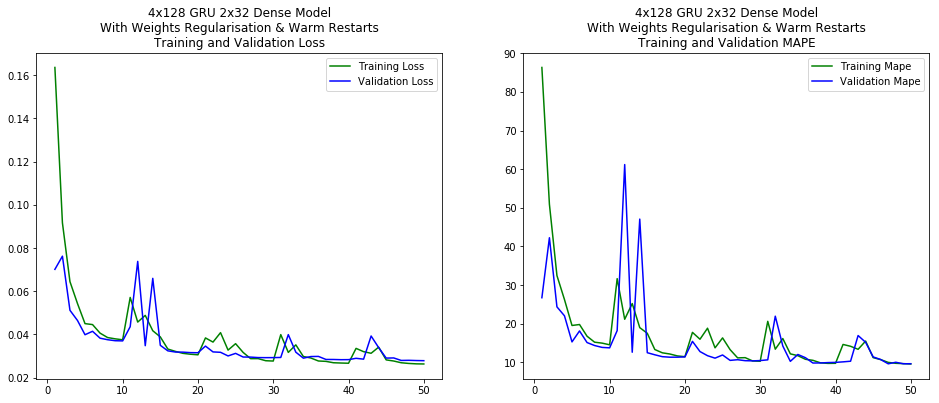

In [35]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mape_skip_zeros']:
        train_mape.append(a_mape)
    for a_mape in h['val_mape_skip_zeros']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model\nWith Weights Regularisation & Warm Restarts\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model\nWith Weights Regularisation & Warm Restarts\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [ ]:
print('Min Training Loss = {}\nMin Validation Loss = {} @ epoch {}\nMin Train MAE = {}\nMin Validation MAE = {}'.format(
    min(train_loss),
    min(val_loss),
    val_loss.index(min(val_loss)),
    min(train_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min()),
    min(val_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min())))

Run 1

After 500 epochs


# ================ BELOW TO BE EDITED =================

## 4x128 GRU, 2x32 Dense Model with L1 (1e-7), L2 (1e-7) Weight + L1 (1e-6), L2 (1e-6) Activity Regularisation

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7), activity_regularizer=l1_l2(1e-6, 1e-6),
                          return_sequences=True, input_shape=(None, mrb_train_split.shape[-1])))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7), activity_regularizer=l1_l2(1e-6, 1e-6),
                          return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7), activity_regularizer=l1_l2(1e-6, 1e-6),
                          return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7),  activity_regularizer=l1_l2(1e-6, 1e-6)))

model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
# model.compile(optimizer=RMSprop(lr=0.001, decay=0.001/50), loss='mae', metrics=['mape'])
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [21]:
gen_train = mu.DataGenerator(mrb_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(mrb_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_split) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [22]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1l2-1e-6-histories-epch200.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1l2-1e-6-epch200.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, None, 128)         50688     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [22]:
t1 = datetime.datetime.now()
print('Training start time = %s' % t1)
history = model.fit_generator(generator=gen_train, epochs=400,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=0)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-02-04 20:04:18.239181

Training Duration = 1:35:30.152314


In [23]:
# histories = []  # for first training session
histories.append(history.history)

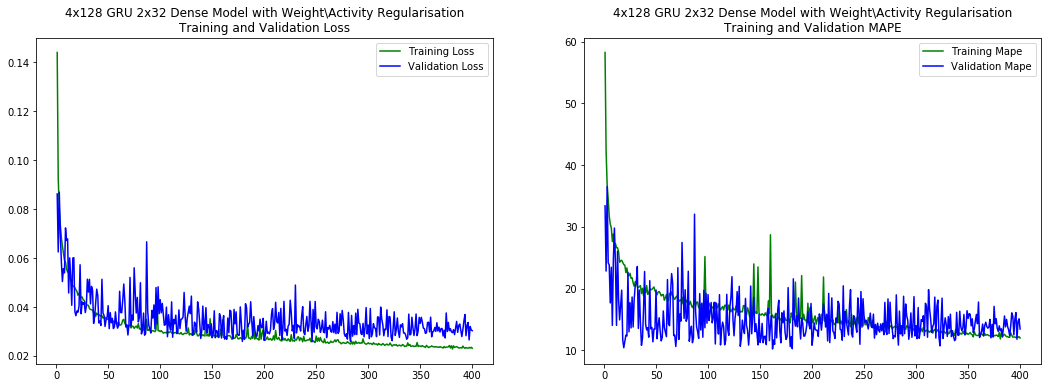

In [24]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in h['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
# plt.xlim((100, 350))
# plt.ylim((0.02, 0.06))
plt.title('4x128 GRU 2x32 Dense Model with Weight\Activity Regularisation\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Weight\Activity Regularisation\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [25]:
print('Train min loss = %f\nValidation min loss = %f\nValidation min epoch = %d' %
      (min(train_loss),
       min(val_loss),
       val_loss.index(min(val_loss))))

Train min loss = 0.022842
Validation min loss = 0.025783
Validation min epoch = 245


In [26]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (mrb_train_df['PWM_30min_avg'].max() - mrb_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (mrb_train_df['PWM_30min_avg'].max() - mrb_train_df['PWM_30min_avg'].min()))))

Train MAE = 2.429906
Validation MAE = 2.742768


In [27]:
gen_pred = mu.DataGenerator(mrb_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                            batch_size=batch_size, step=step)
mrb_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
mrb_train_preds.shape

(29754, 1)

In [28]:
mrb_train_preds_withnan = np.full((mrb_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_train_data)):
    if mrb_train_data[i, 0] > -1:
        mrb_train_preds_withnan[i] = mrb_train_preds[j]
        j += 1
mrb_train_preds_withnan.shape

(31616, 1)

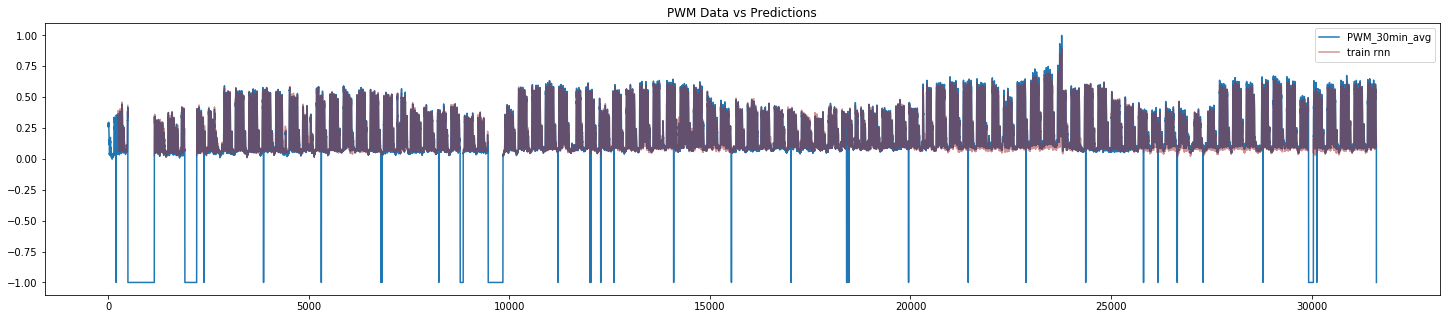

In [29]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_train_data.shape[0]), mrb_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(mrb_train_data.shape[0]), mrb_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

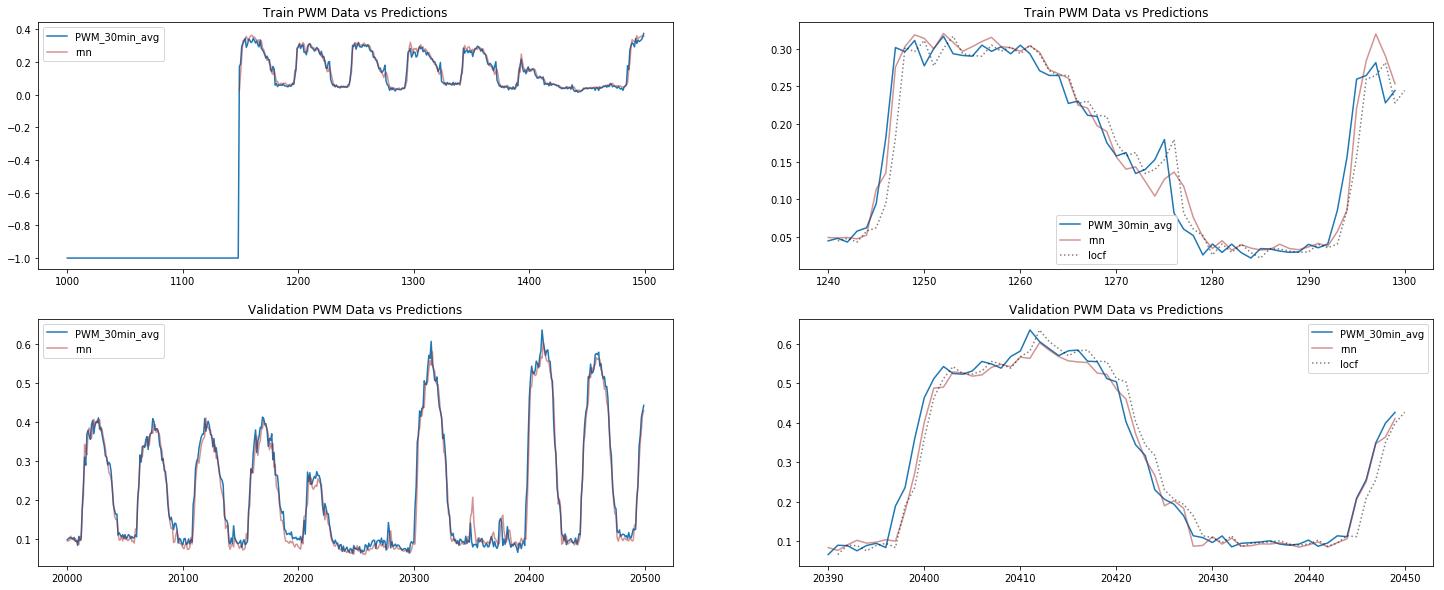

In [30]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), mrb_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), mrb_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), mrb_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), mrb_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), mrb_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), mrb_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), mrb_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), mrb_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), mrb_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), mrb_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [31]:
model.save('base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1l2-1e-6.h5')

In [32]:
with open('base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1l2-1e-6-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Model with L1 (1e-7), L2 (1e-7) Weight + L1 (5e-7), L2 (5e-7) Activity Regularisation

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7), activity_regularizer=l1_l2(5e-7, 5e-7),
                          return_sequences=True, input_shape=(None, mrb_train_split.shape[-1])))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7), activity_regularizer=l1_l2(5e-7, 5e-7),
                          return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7), activity_regularizer=l1_l2(5e-7, 5e-7),
                          return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7),  activity_regularizer=l1_l2(5e-7, 5e-7)))

model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
# model.compile(optimizer=RMSprop(lr=0.001, decay=0.001/50), loss='mae', metrics=['mape'])
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, None, 128)         50688     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [21]:
gen_train = mu.DataGenerator(mrb_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(mrb_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_split) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [22]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1l2-5e-7-histories-epch200.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1l2-5e-7-epch200.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 128)         50688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [22]:
t1 = datetime.datetime.now()
print('Training start time = {}'.format(t1))
history = model.fit_generator(generator=gen_train, epochs=400,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-02-04 21:59:03.245949
Epoch 1/400
 - 16s - loss: 0.1156 - mean_absolute_percentage_error: 54.3851 - val_loss: 0.0841 - val_mean_absolute_percentage_error: 20.9643
Epoch 2/400
 - 14s - loss: 0.0763 - mean_absolute_percentage_error: 36.9113 - val_loss: 0.0785 - val_mean_absolute_percentage_error: 29.0578
Epoch 3/400
 - 14s - loss: 0.0656 - mean_absolute_percentage_error: 32.3830 - val_loss: 0.0634 - val_mean_absolute_percentage_error: 22.1259
Epoch 4/400
 - 14s - loss: 0.0599 - mean_absolute_percentage_error: 29.1638 - val_loss: 0.0642 - val_mean_absolute_percentage_error: 27.4468
Epoch 5/400
 - 14s - loss: 0.0569 - mean_absolute_percentage_error: 28.8037 - val_loss: 0.0638 - val_mean_absolute_percentage_error: 26.7721
Epoch 6/400
 - 14s - loss: 0.0528 - mean_absolute_percentage_error: 27.3309 - val_loss: 0.0439 - val_mean_absolute_percentage_error: 13.6155
Epoch 7/400
 - 14s - loss: 0.0520 - mean_absolute_percentage_error: 26.7466 - val_loss: 0.0621 - val_mean

Epoch 59/400
 - 14s - loss: 0.0291 - mean_absolute_percentage_error: 15.7325 - val_loss: 0.0417 - val_mean_absolute_percentage_error: 16.5200
Epoch 60/400
 - 14s - loss: 0.0309 - mean_absolute_percentage_error: 16.4638 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 11.0875
Epoch 61/400
 - 14s - loss: 0.0288 - mean_absolute_percentage_error: 15.9081 - val_loss: 0.0409 - val_mean_absolute_percentage_error: 14.0902
Epoch 62/400
 - 14s - loss: 0.0293 - mean_absolute_percentage_error: 16.4675 - val_loss: 0.0360 - val_mean_absolute_percentage_error: 14.7086
Epoch 63/400
 - 14s - loss: 0.0290 - mean_absolute_percentage_error: 16.4073 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 10.4163
Epoch 64/400
 - 14s - loss: 0.0286 - mean_absolute_percentage_error: 16.0844 - val_loss: 0.0446 - val_mean_absolute_percentage_error: 19.0831
Epoch 65/400
 - 14s - loss: 0.0285 - mean_absolute_percentage_error: 15.9588 - val_loss: 0.0312 - val_mean_absolute_percentage_error: 15.7234
Epoch 

Epoch 117/400
 - 14s - loss: 0.0258 - mean_absolute_percentage_error: 14.6438 - val_loss: 0.0361 - val_mean_absolute_percentage_error: 19.6316
Epoch 118/400
 - 14s - loss: 0.0259 - mean_absolute_percentage_error: 14.8162 - val_loss: 0.0388 - val_mean_absolute_percentage_error: 18.3737
Epoch 119/400
 - 14s - loss: 0.0259 - mean_absolute_percentage_error: 15.0304 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 10.2359
Epoch 120/400
 - 14s - loss: 0.0262 - mean_absolute_percentage_error: 15.4765 - val_loss: 0.0288 - val_mean_absolute_percentage_error: 11.6317
Epoch 121/400
 - 14s - loss: 0.0255 - mean_absolute_percentage_error: 14.2509 - val_loss: 0.0347 - val_mean_absolute_percentage_error: 17.4622
Epoch 122/400
 - 14s - loss: 0.0261 - mean_absolute_percentage_error: 15.2083 - val_loss: 0.0255 - val_mean_absolute_percentage_error: 9.8766
Epoch 123/400
 - 14s - loss: 0.0253 - mean_absolute_percentage_error: 14.2650 - val_loss: 0.0361 - val_mean_absolute_percentage_error: 16.8532


Epoch 175/400
 - 14s - loss: 0.0242 - mean_absolute_percentage_error: 13.8874 - val_loss: 0.0238 - val_mean_absolute_percentage_error: 9.8889
Epoch 176/400
 - 14s - loss: 0.0242 - mean_absolute_percentage_error: 14.0126 - val_loss: 0.0300 - val_mean_absolute_percentage_error: 13.8602
Epoch 177/400
 - 14s - loss: 0.0246 - mean_absolute_percentage_error: 14.2990 - val_loss: 0.0238 - val_mean_absolute_percentage_error: 9.8034
Epoch 178/400
 - 14s - loss: 0.0241 - mean_absolute_percentage_error: 14.1646 - val_loss: 0.0302 - val_mean_absolute_percentage_error: 14.8795
Epoch 179/400
 - 14s - loss: 0.0241 - mean_absolute_percentage_error: 14.1006 - val_loss: 0.0378 - val_mean_absolute_percentage_error: 18.4332
Epoch 180/400
 - 14s - loss: 0.0242 - mean_absolute_percentage_error: 14.1666 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 10.1654
Epoch 181/400
 - 14s - loss: 0.0244 - mean_absolute_percentage_error: 14.2938 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 13.6024
E

Epoch 233/400
 - 14s - loss: 0.0230 - mean_absolute_percentage_error: 13.2255 - val_loss: 0.0323 - val_mean_absolute_percentage_error: 14.2558
Epoch 234/400
 - 14s - loss: 0.0238 - mean_absolute_percentage_error: 13.9437 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 11.7852
Epoch 235/400
 - 14s - loss: 0.0229 - mean_absolute_percentage_error: 13.4535 - val_loss: 0.0367 - val_mean_absolute_percentage_error: 19.7673
Epoch 236/400
 - 14s - loss: 0.0233 - mean_absolute_percentage_error: 13.8066 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 13.1537
Epoch 237/400
 - 14s - loss: 0.0232 - mean_absolute_percentage_error: 13.6770 - val_loss: 0.0308 - val_mean_absolute_percentage_error: 15.1636
Epoch 238/400
 - 14s - loss: 0.0227 - mean_absolute_percentage_error: 13.3305 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 11.5540
Epoch 239/400
 - 14s - loss: 0.0228 - mean_absolute_percentage_error: 13.2981 - val_loss: 0.0253 - val_mean_absolute_percentage_error: 11.3841

Epoch 291/400
 - 14s - loss: 0.0221 - mean_absolute_percentage_error: 12.6992 - val_loss: 0.0263 - val_mean_absolute_percentage_error: 11.9489
Epoch 292/400
 - 14s - loss: 0.0225 - mean_absolute_percentage_error: 13.0010 - val_loss: 0.0299 - val_mean_absolute_percentage_error: 16.3601
Epoch 293/400
 - 14s - loss: 0.0220 - mean_absolute_percentage_error: 12.6790 - val_loss: 0.0295 - val_mean_absolute_percentage_error: 13.3147
Epoch 294/400
 - 14s - loss: 0.0220 - mean_absolute_percentage_error: 12.6609 - val_loss: 0.0299 - val_mean_absolute_percentage_error: 14.3125
Epoch 295/400
 - 14s - loss: 0.0218 - mean_absolute_percentage_error: 12.5811 - val_loss: 0.0300 - val_mean_absolute_percentage_error: 14.2468
Epoch 296/400
 - 14s - loss: 0.0287 - mean_absolute_percentage_error: 18.5209 - val_loss: 0.0308 - val_mean_absolute_percentage_error: 15.7796
Epoch 297/400
 - 14s - loss: 0.0218 - mean_absolute_percentage_error: 12.5314 - val_loss: 0.0293 - val_mean_absolute_percentage_error: 13.9303

Epoch 349/400
 - 14s - loss: 0.0212 - mean_absolute_percentage_error: 12.3100 - val_loss: 0.0332 - val_mean_absolute_percentage_error: 15.6816
Epoch 350/400
 - 14s - loss: 0.0209 - mean_absolute_percentage_error: 11.8080 - val_loss: 0.0341 - val_mean_absolute_percentage_error: 16.5055
Epoch 351/400
 - 14s - loss: 0.0211 - mean_absolute_percentage_error: 12.0670 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 12.3332
Epoch 352/400
 - 14s - loss: 0.0209 - mean_absolute_percentage_error: 12.0897 - val_loss: 0.0284 - val_mean_absolute_percentage_error: 14.2062
Epoch 353/400
 - 14s - loss: 0.0211 - mean_absolute_percentage_error: 11.9575 - val_loss: 0.0293 - val_mean_absolute_percentage_error: 14.3810
Epoch 354/400
 - 14s - loss: 0.0210 - mean_absolute_percentage_error: 12.1912 - val_loss: 0.0302 - val_mean_absolute_percentage_error: 14.5671
Epoch 355/400
 - 14s - loss: 0.0210 - mean_absolute_percentage_error: 12.0671 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 13.0384

In [23]:
# histories = []  ## if first training session
histories.append(history.history)

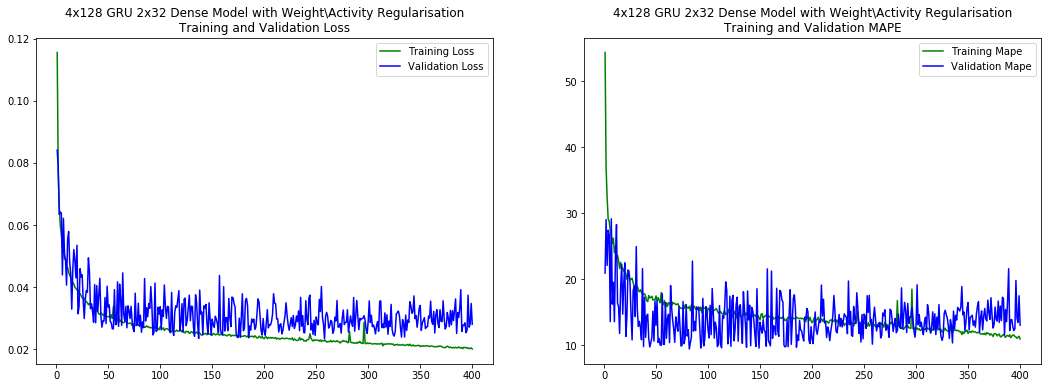

In [24]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in h['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
# plt.xlim((100, 350))
# plt.ylim((0.02, 0.06))
plt.title('4x128 GRU 2x32 Dense Model with Weight\Activity Regularisation\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Weight\Activity Regularisation\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [25]:
print('Train min loss = %f\nValidation min loss = %f\nValidation min epoch = %d' %
      (min(train_loss),
       min(val_loss),
       val_loss.index(min(val_loss))))

Train min loss = 0.020066
Validation min loss = 0.023274
Validation min epoch = 257


In [26]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (mrb_train_df['PWM_30min_avg'].max() - mrb_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (mrb_train_df['PWM_30min_avg'].max() - mrb_train_df['PWM_30min_avg'].min()))))

Train MAE = 2.134601
Validation MAE = 2.475910


In [27]:
gen_pred = mu.DataGenerator(mrb_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                            batch_size=batch_size, step=step)
mrb_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
mrb_train_preds.shape

(29754, 1)

In [28]:
mrb_train_preds_withnan = np.full((mrb_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_train_data)):
    if mrb_train_data[i, 0] > -1:
        mrb_train_preds_withnan[i] = mrb_train_preds[j]
        j += 1
mrb_train_preds_withnan.shape

(31616, 1)

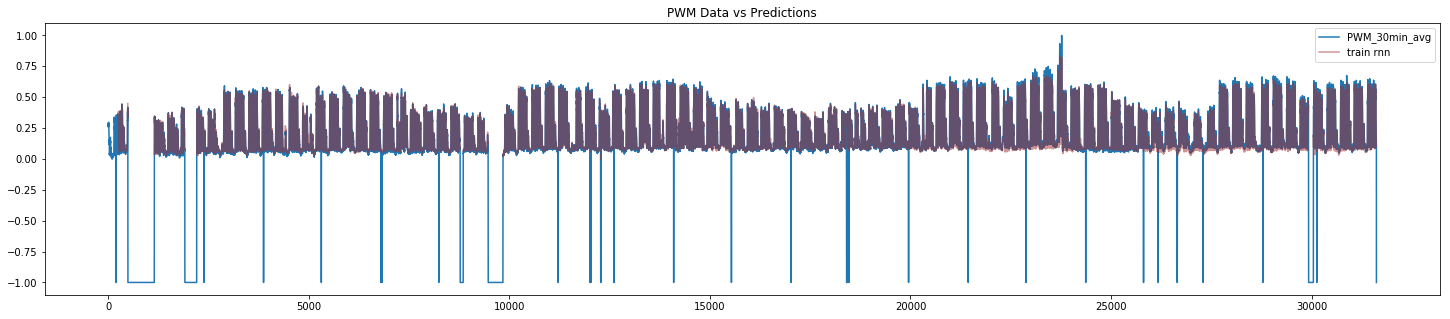

In [29]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_train_data.shape[0]), mrb_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(mrb_train_data.shape[0]), mrb_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

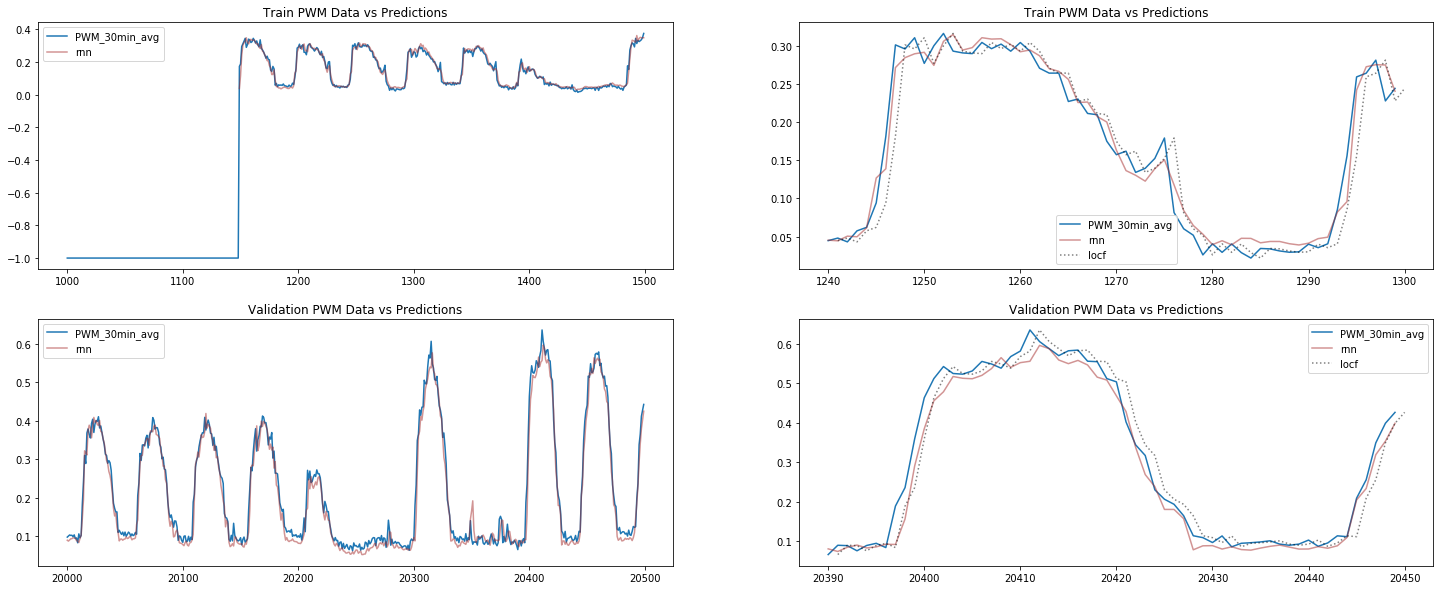

In [30]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), mrb_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), mrb_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), mrb_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), mrb_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), mrb_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), mrb_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), mrb_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), mrb_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), mrb_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), mrb_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [31]:
model.save('base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1l2-5e-7.h5')

In [32]:
with open('base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1l2-5e-7-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Model with L1 (1e-7), L2 (1e-7) Weight + L1 (1e-7), L2 (1e-7) Activity Regularisation

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7), activity_regularizer=l1_l2(1e-7, 1e-7),
                          return_sequences=True, input_shape=(None, mrb_train_split.shape[-1])))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7), activity_regularizer=l1_l2(1e-7, 1e-7),
                          return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7), activity_regularizer=l1_l2(1e-7, 1e-7),
                          return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7),  activity_regularizer=l1_l2(1e-7, 1e-7)))

model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
# model.compile(optimizer=RMSprop(lr=0.001, decay=0.001/50), loss='mae', metrics=['mape'])
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, None, 128)         50688     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [21]:
gen_train = mu.DataGenerator(mrb_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(mrb_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_split) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [22]:
t1 = datetime.datetime.now()
print('Training start time = {}'.format(t1))
history = model.fit_generator(generator=gen_train, epochs=400,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=0)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-02-05 21:24:16.933420

Training Duration = 1:34:46.138536


In [23]:
# histories = []  ## if first training session
histories.append(history.history)

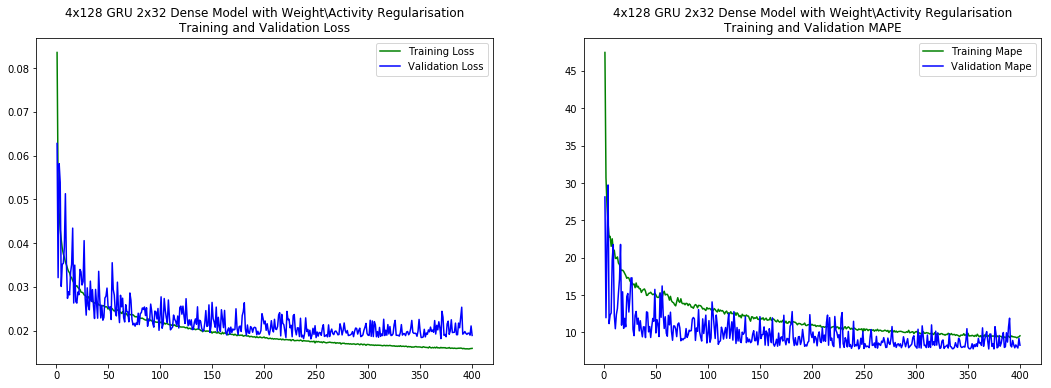

In [24]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in h['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
# plt.xlim((100, 350))
# plt.ylim((0.02, 0.06))
plt.title('4x128 GRU 2x32 Dense Model with Weight\Activity Regularisation\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Weight\Activity Regularisation\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [25]:
print('Train min loss = %f\nValidation min loss = %f\nValidation min epoch = %d' %
      (min(train_loss),
       min(val_loss),
       val_loss.index(min(val_loss))))

Train min loss = 0.015781
Validation min loss = 0.018089
Validation min epoch = 244


In [26]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (mrb_train_df['PWM_30min_avg'].max() - mrb_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (mrb_train_df['PWM_30min_avg'].max() - mrb_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.678781
Validation MAE = 1.924339


In [27]:
gen_pred = mu.DataGenerator(mrb_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                            batch_size=batch_size, step=step)
mrb_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
mrb_train_preds.shape

(29754, 1)

In [28]:
mrb_train_preds_withnan = np.full((mrb_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_train_data)):
    if mrb_train_data[i, 0] > -1:
        mrb_train_preds_withnan[i] = mrb_train_preds[j]
        j += 1
mrb_train_preds_withnan.shape

(31616, 1)

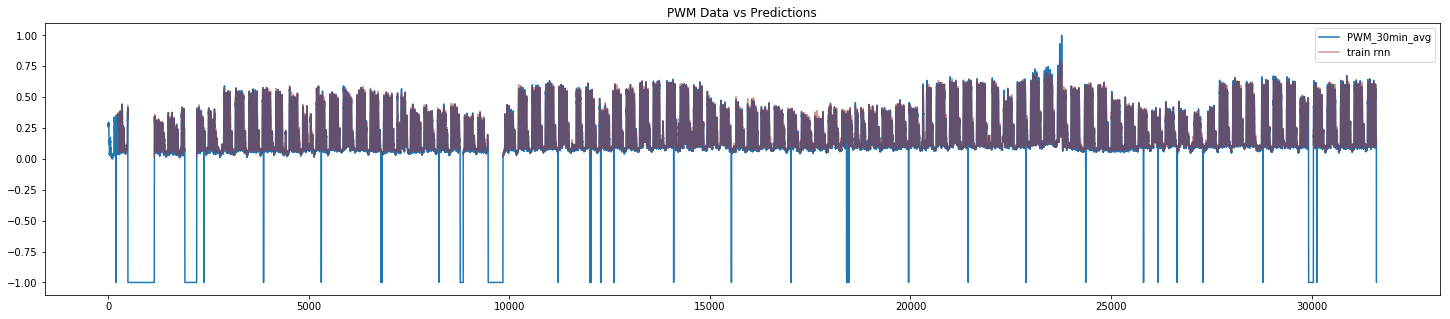

In [29]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_train_data.shape[0]), mrb_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(mrb_train_data.shape[0]), mrb_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

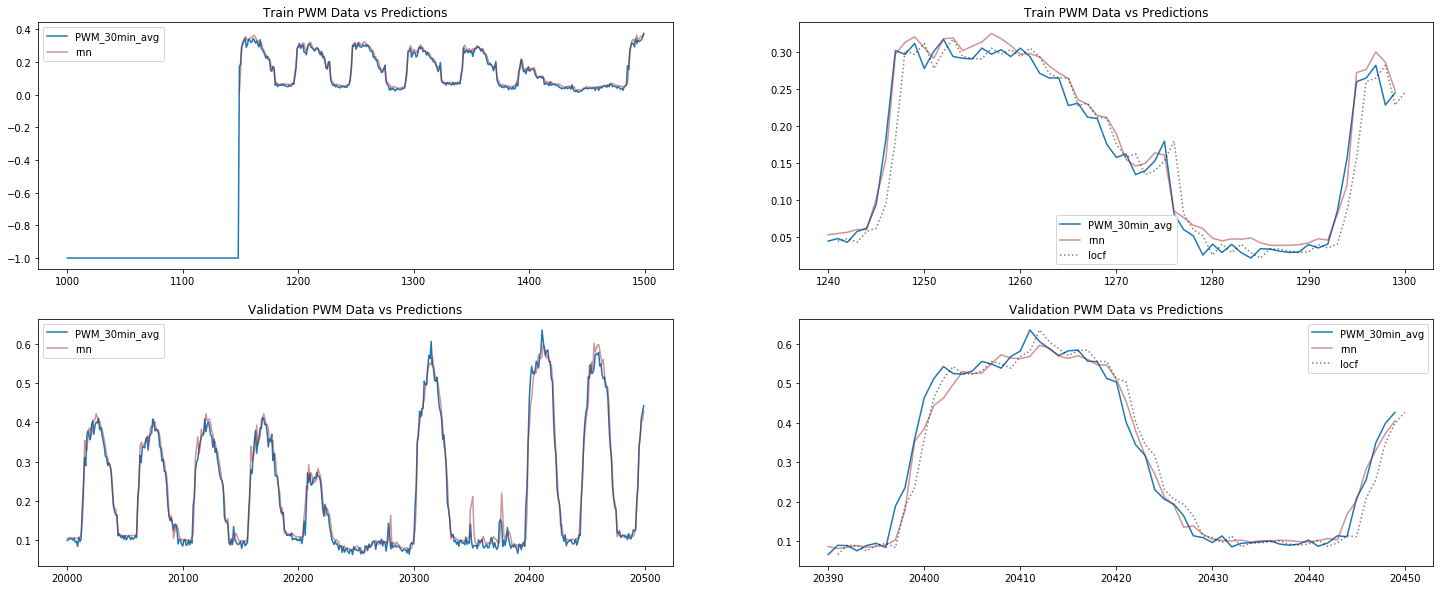

In [30]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), mrb_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), mrb_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), mrb_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), mrb_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), mrb_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), mrb_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), mrb_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), mrb_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), mrb_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), mrb_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [31]:
model.save('base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1l2-1e-7.h5')

In [32]:
with open('base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1l2-1e-7-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Model with L1 (1e-7), L2 (1e-7) Weight + L1 (1e-7) Activity Regularisation

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
callbacks_list = [
    ModelCheckpoint(
        # filepath='base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1-1e-7.{epoch:02d}-{val_loss:.2f}.h5',
        filepath='base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1-1e-7.best.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

In [21]:
model = Sequential()
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7), activity_regularizer=l1(1e-7),
                          return_sequences=True, input_shape=(None, mrb_train_split.shape[-1])))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7), activity_regularizer=l1(1e-7),
                          return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7), activity_regularizer=l1(1e-7),
                          return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7),  activity_regularizer=l1(1e-7)))

model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
# model.compile(optimizer=RMSprop(lr=0.001, decay=0.001/50), loss='mae', metrics=['mape'])
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, None, 128)         50688     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [22]:
gen_train = mu.DataGenerator(mrb_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(mrb_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_split) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [ ]:
# # Temporary - to remove after training is completed
# # Load previous history
# with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout-histories.pkl'), 'rb') as infile:
#     histories = pickle.load(infile)
# # Load previous model
# from keras.models import load_model
# model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout.h5'))
# model.summary()

In [23]:
t1 = datetime.datetime.now()
print('Training start time = {}'.format(t1))
history = model.fit_generator(generator=gen_train, epochs=400,
                              callbacks=callbacks_list,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=0)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-02-07 10:10:07.737654

Training Duration = 1:30:50.152123


In [24]:
# histories = [] # for first training session
histories.append(history.history)

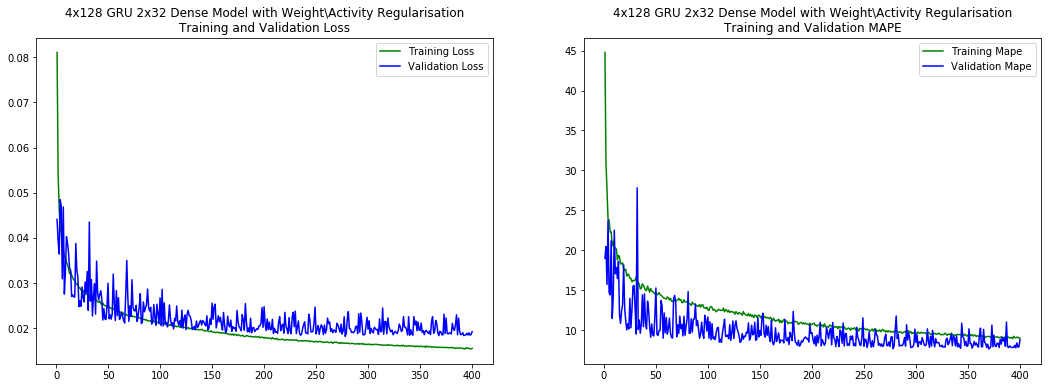

In [25]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in h['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
# plt.xlim((100, 350))
# plt.ylim((0.02, 0.06))
plt.title('4x128 GRU 2x32 Dense Model with Weight\Activity Regularisation\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Weight\Activity Regularisation\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [26]:
print('Train min loss = %f\nValidation min loss = %f\nValidation min epoch = %d' %
      (min(train_loss),
       min(val_loss),
       val_loss.index(min(val_loss))))

Train min loss = 0.015407
Validation min loss = 0.018187
Validation min epoch = 277


In [27]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (mrb_train_df['PWM_30min_avg'].max() - mrb_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss[-10:]) * (mrb_train_df['PWM_30min_avg'].max() - mrb_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.639040
Validation MAE = 1.954555


In [28]:
# Load best model
best_model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1-1e-7.best.h5'))
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, None, 128)         50688     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [29]:
gen_pred = mu.DataGenerator(mrb_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                            batch_size=batch_size, step=step)
mrb_train_preds = best_model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
mrb_train_preds.shape

(29754, 1)

In [30]:
mrb_train_preds_withnan = np.full((mrb_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_train_data)):
    if mrb_train_data[i, 0] > -1:
        mrb_train_preds_withnan[i] = mrb_train_preds[j]
        j += 1
mrb_train_preds_withnan.shape

(31616, 1)

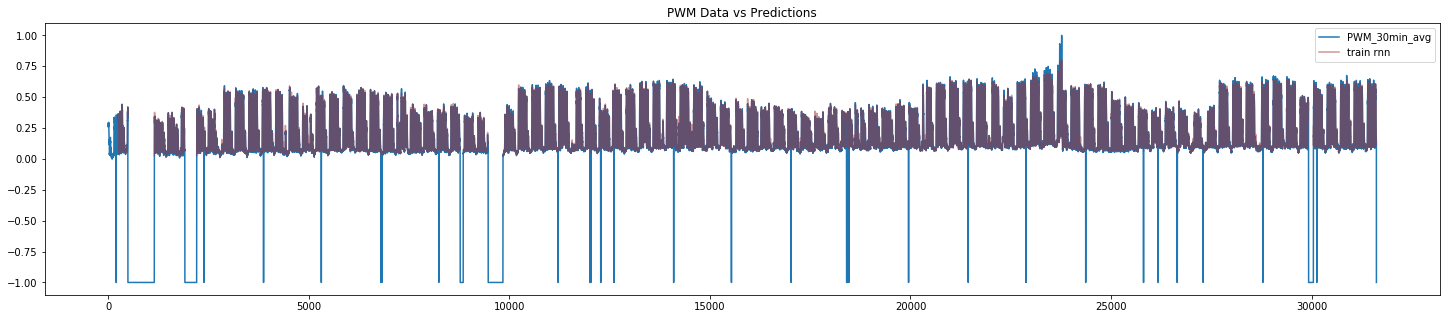

In [31]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_train_data.shape[0]), mrb_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(mrb_train_data.shape[0]), mrb_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

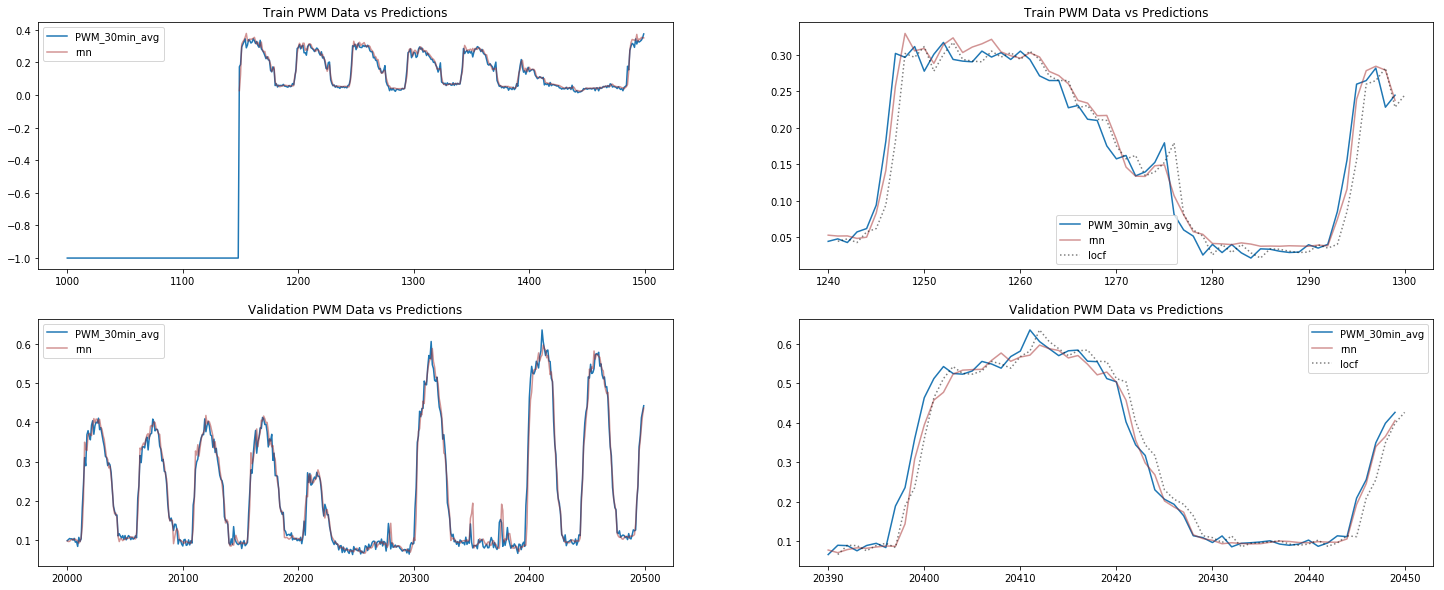

In [33]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), mrb_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), mrb_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), mrb_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), mrb_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), mrb_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), mrb_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), mrb_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), mrb_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), mrb_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), mrb_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [34]:
model.save('base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1-1e-7-histories-epch400.h5')

In [35]:
with open('base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1-1e-7-histories-epch400.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)